In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [3]:
#레이블 생성 함수

TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(
    df: pd.DataFrame,
    year_month: str,
    total_thres: int = TOTAL_THRES,
    print_log: bool = False
):
    df = df.copy()

    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]

    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month

    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()

    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')

    return label

In [4]:
# 평가지표 함수

def print_score(label: List[float], pred: List[float], prob_thres: float = 0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

In [5]:
data = pd.read_csv("/content/drive/MyDrive/머신러닝 거의 총정리 느낌/boostcourse ai224 codes/input/train.csv", parse_dates=["order_date"])
print(data.shape)
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [6]:
# 데이터 탐색

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


In [7]:
print('null', '\n',data.isna().sum())
print('-------------------')
print('null ratio', '\n',data.isna().sum()/data.shape[0])

null 
 order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64
-------------------
null ratio 
 order_id       0.0
product_id     0.0
description    0.0
quantity       0.0
order_date     0.0
price          0.0
customer_id    0.0
country        0.0
total          0.0
dtype: float64


In [8]:
data.describe()

,quantity,order_date,price,customer_id,total
count,780502.000000,780502,780502.000000,780502.000000,780502.000000
mean,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,33.715373
min,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,-127352.940000
25%,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,7.260000
50%,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,19.470000
75%,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,32.175000
max,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,127352.940000
std,143.906302,NaN,119.042266,1695.765797,274.207403


In [9]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,NaN,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,NaN,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,NaN,33.715373
min,NaN,NaN,NaN,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,NaN,32.175000
max,NaN,NaN,NaN,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,NaN,127352.940000


In [10]:
# 베이스라인 모델
'''
    머신러닝 모델 없이 입력인자으로 받는 year_month의 이전 달 총 구매액을 구매 확률로 예측하는 베이스라인 모델
'''
def baseline_no_ml(df: pd.DataFrame, year_month: str, total_thres=TOTAL_THRES):
    # year_month에 해당하는 label 데이터 생성
    month = generate_label(df, year_month)

    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_d = d - dateutil.relativedelta.relativedelta(months=1)
    prev_d = prev_d.strftime('%Y-%m')

    # 이전 월에 해당하는 label 데이터 생성
    previous_month = generate_label(df, prev_d)

    # merge하기 위해 컬럼명 변경
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')

    # 거래내역이 없는 고객의 구매액을 0으로 채움
    month['previous_total'] = month['previous_total'].fillna(0)
    # 이전 월의 총 구매액을 구매액 임계값으로 나눠서 예측 확률로 계산
    month['probability'] = month['previous_total'] / total_thres

    # 이전 월 총 구매액이 구매액 임계값을 넘어서 1보다 클 경우 예측 확률을 1로 변경
    month.loc[month['probability'] > 1, 'probability'] = 1

    # 이전 월 총 구매액이 마이너스(주문 환불)일 경우 예측 확률을 0으로 변경
    month.loc[month['probability'] < 0, 'probability'] = 0

    return month['probability']

In [11]:
label_2011_11 = generate_label(data, '2011-11')['label']

,count
label,
0,4534
1,1188


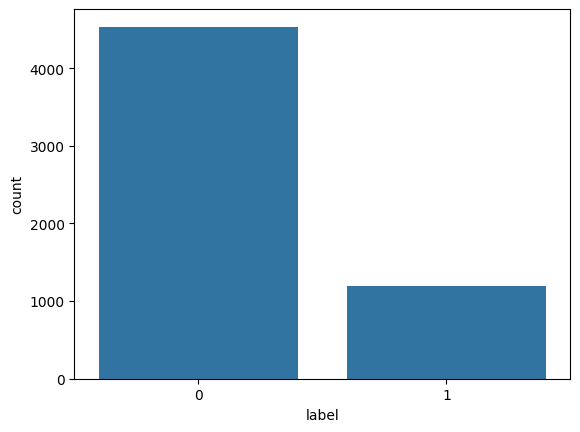

In [12]:
sns.countplot(x ='label', data=label_2011_11.to_frame());
label_2011_11.value_counts()

In [13]:
test_preds_2011_11 = baseline_no_ml(data, '2011-11')
print_score(label_2011_11, test_preds_2011_11)

Precision: 0.42468
Recall: 0.39394
F1 Score: 0.40873
ROC AUC Score: 0.63010


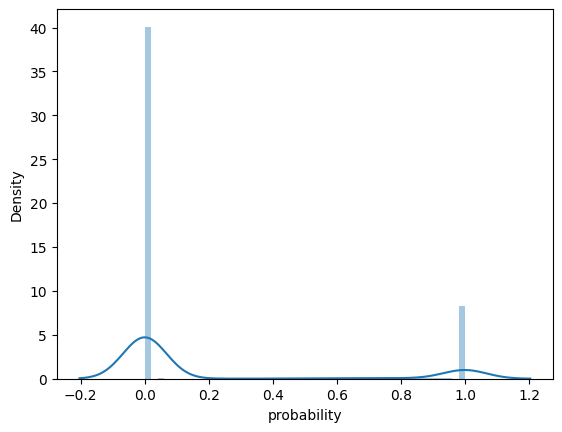

In [14]:
sns.distplot(test_preds_2011_11)
plt.show()

In [15]:
test_preds = baseline_no_ml(data, '2011-12')

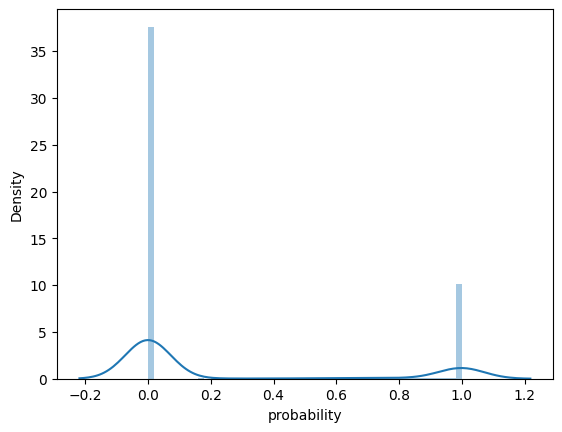

In [16]:
sns.distplot(test_preds)
plt.show()

In [17]:
output_dir = '/content/drive/MyDrive/머신러닝 거의 총정리 느낌'
os.makedirs(output_dir, exist_ok=True)
test_preds.to_csv(os.path.join(output_dir, 'output.csv'), index=False)